## Welcome to the `Segformer Starter Block` Workshop!

In this workshop, we'll learn about building blocks of Segformer architecture. 
1. **Overlap Patch Embedding**. A method to convert images to sequence of overlapping patches 
2. **Efficient Self-Attention** - 1st Core component of all Transformer based models. 
3. **Mix-FeedForward module** - 2nd core component of Transformer models. Along with Self-Attention, forms single Transformer block
4. **Transformer block** - Self-attention + Mix FFN + Layer Norm forms a basic Tranformer block

We'll cover these concepts in this notebook

In [ ]:
!pip install einops
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 453 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 8.6 MB/s 
     |████████████████████████████████| 182 kB 53.4 MB/s 


In [ ]:
# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, trunc_normal_

# Segformer specific imports
from einops import rearrange

## 1. Overlap Patch Embedding


- Vision Transformers (ViT) pioneered the idea of Overlapping image patches.
- `ViT uses patches of size 16x16 along with positional encodings`. Hence the paper name (Image is worth 16x16 words)
- **In Segformer, authors propose smaller patch size (4x4) for semantic segmentation as its a dense prediction task**
- **No positional encoding for patches**

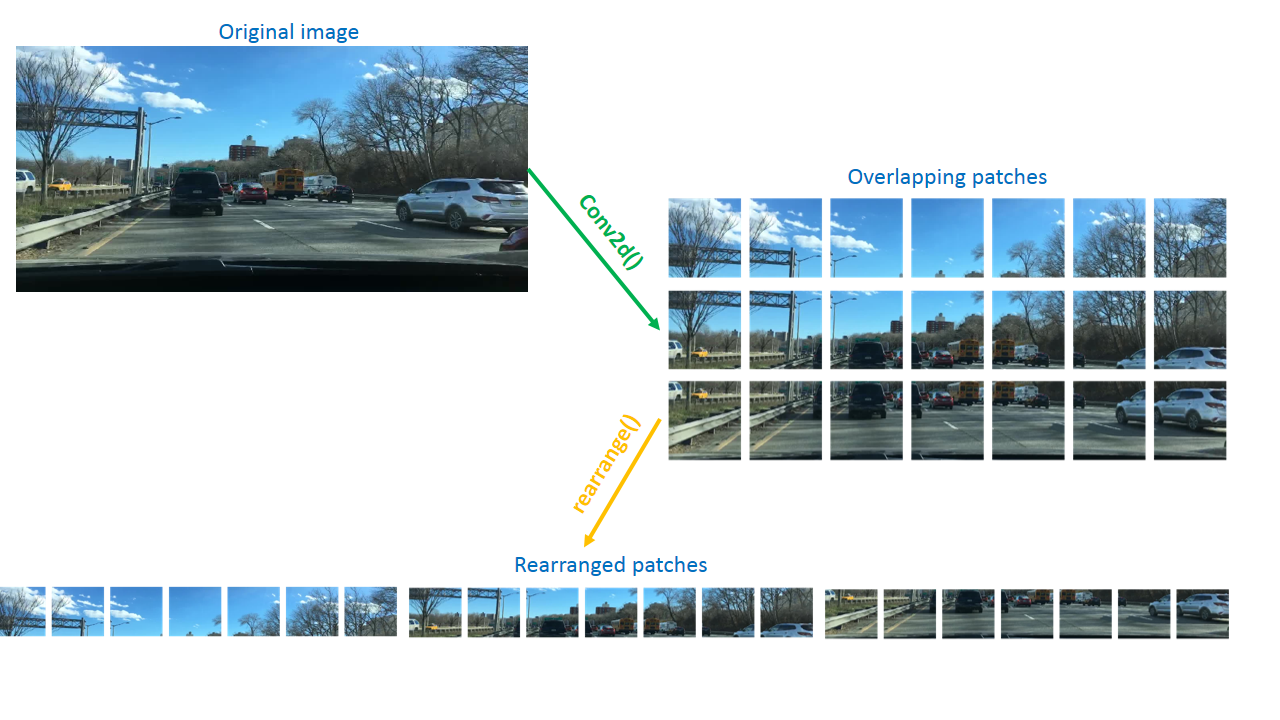

In [ ]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride, padding=patch_size//2)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        # [B,C,H,W] -> [B, HW, C]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, H, W

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/test_img.jpeg

--2022-11-18 05:37:15--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/test_img.jpeg
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 52.95.155.82
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|52.95.155.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23690 (23K) [image/jpeg]
Saving to: ‘test_img.jpeg’

test_img.jpeg       100%[===================>]  23.13K  --.-KB/s    in 0.1s    

2022-11-18 05:37:16 (166 KB/s) - ‘test_img.jpeg’ saved [23690/23690]



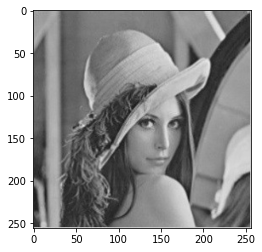

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread('test_img.jpeg'))
plt.show()

In [ ]:
from torchvision import transforms
input_img = cv2.imread('test_img.jpeg')
convert_tensor = transforms.ToTensor()
overlap_patch_embed_input = convert_tensor(input_img).reshape(1,3,256,256)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)


overlap_patch_embed_input.shape torch.Size([1, 3, 256, 256])


In [ ]:
model = overlap_patch_embed(patch_size= 7, stride =4, in_chans =3, embed_dim = 64)

In [ ]:
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

overlap_patch_embed_output.shape torch.Size([1, 4096, 64])


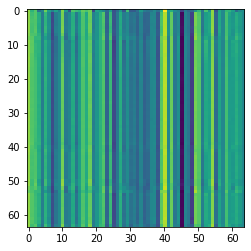

In [ ]:
row = 0
col = 0
plt.imshow(overlap_patch_embed_output[0].detach().numpy()[row:row+64,col:col+64])
plt.show()

Okay, because we have used a convolution with untrained weights, we might as well use a dummy input:

In [ ]:
overlap_patch_embed_input = torch.Tensor(1, 3, 256, 256)

From which the process is the same:

In [ ]:
model = overlap_patch_embed(patch_size= 7, stride =4, in_chans =3, embed_dim = 64)
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

overlap_patch_embed_input.shape torch.Size([1, 3, 256, 256])
overlap_patch_embed_output.shape torch.Size([1, 4096, 64])


## 2. Efficient Multi-head Self-Attention

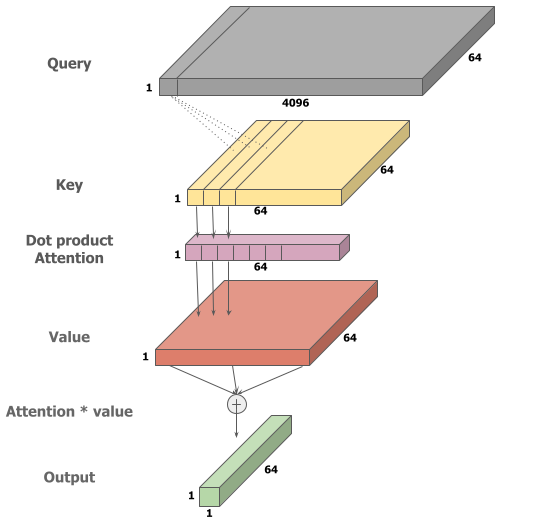

In [ ]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from 
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)
        
        # dropout
        self.proj_drop = nn.Dropout(self.dropout_p)

    def forward(self, x, h, w):
        B, N, C = x.shape
        # [B, N, C] -> [B, N, num_heads, embed_dim] -> [B, num_heads, N, embed_dim]
        q = self.q(x)
        q = rearrange(q, 'b n (h e) -> b n h e', h=self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            # since self.sr is doing Conv2d, we need shape = [B, C, H, W] to do that
            x_ = rearrange(x, 'b (h w) c -> b c h w', h=h)
            # print("x_ before self.sr: ", x_.shape)
            x_ = self.sr(x_)
            # print("x_ after self.sr: ", x_.shape)
            # reshape from [B, C, H, W] back to [B, N, C]
            x_ = rearrange(x_, 'b c h w -> b (h w) c')
            # print("x_ reshaped: ", x_.shape)
            x_ = self.norm(x_)
            kv = self.kv(x_)
            # [B, N, C*2] -> [B, N, 2, num_heads, embed_dim] -> [2, B, num_heads, N, embed_dim]
            kv = rearrange(kv, 'b n (s h e) -> b n s h e', s=2, h=self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            # [B, N, C*2] -> [B, N, 2, num_heads, embed_dim] -> [2, B, num_heads, N, embed_dim]
            kv = self.kv(x)
            kv = rearrange(kv, 'b n (s h e) -> b n s h e', s=2, h=self.num_heads).permute(2, 0, 3, 1, 4)
        
        # seperate kv. k = [B, num_heads, N, embed_dim], v = [B, num_heads, N, embed_dim]
        k, v = kv.unbind(0)
        attn = (q @ k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)

        output = attn @ v
        # reshape from [B, num_heads, N, embed_dim] to [B, N, C] (C = concatenate embed_dim along num_heads)
        # output_ = output.transpose(1,2).reshape(B,N,C)
        output = rearrange(output, 'b h n e -> b n (h e)')
        # print("is the same: ", output==output_)
        output = self.proj(output)  # (attn_dim, attn_dim)
        output = self.proj_drop(output)
        return output

In [ ]:
## Test with sample inputs
efficient_self_attention_input = torch.Tensor(1, 4096, 64)
model = efficient_self_attention(attn_dim= 64, num_heads = 1, 
                                 dropout_p = 0, sr_ratio = 8)
efficient_self_attention_output = model(efficient_self_attention_input, h=64, w = 64)
print("efficient_self_attention_input.shape", efficient_self_attention_input.shape)
print("efficient_self_attention_output.shape", efficient_self_attention_output.shape)

efficient_self_attention_input.shape torch.Size([1, 4096, 64])
efficient_self_attention_output.shape torch.Size([1, 4096, 64])


## 3. Mix FeedForward Module

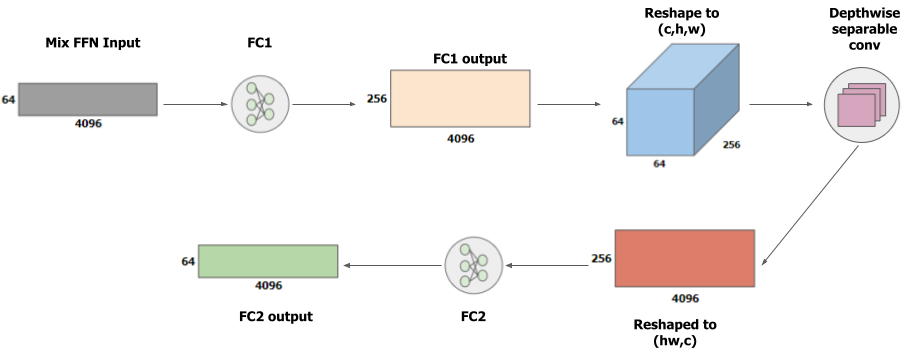

In [ ]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        # using depthwise convolution
        self.conv_3x3 = nn.Conv2d(hidden_features, hidden_features, kernel_size=3, 
                                  padding=1, groups=hidden_features)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x, h, w):
        # MLP 1
        output = self.fc1(x)  # [B, N, C]
        # reshape from [B, N, C] to [B, C, H, W] for Conv2d
        output = rearrange(output, 'b (h w) c -> b c h w', h=h)
        output = self.conv_3x3(output)
        # reshape back to [B, N, C]
        output = rearrange(output, 'b c h w -> b (h w) c')
        # GELU
        output = self.gelu(output)
        output = self.drop(output)
        # MLP 2
        output = self.fc2(output)
        output = self.drop(output)
        return output

In [ ]:
## Test with sample inputs
mix_feedforward_input = torch.Tensor(1, 4096, 64)
model = mix_feedforward(in_features=64, out_features=64, hidden_features=256)
mix_feedforward_output = model(mix_feedforward_input, h=64, w = 64)
print("mix_feedforward_input.shape", mix_feedforward_input.shape)
print("mix_feedforward_output.shape", mix_feedforward_output.shape)

mix_feedforward_input.shape torch.Size([1, 4096, 64])
mix_feedforward_output.shape torch.Size([1, 4096, 64])


## 4. Transformer Block

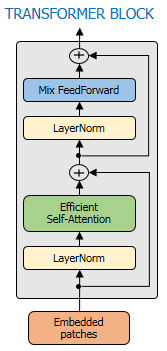

In [ ]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, drop_path_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads, 
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)                    
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.drop_path = DropPath(drop_path_p) if drop_path_p > 0. else nn.Identity() 

    def forward(self, x, h, w):
        # print(x.shape)
        x1 = x
        x = self.norm1(x)
        x = self.drop_path(self.attn(x, h, w))
        x += x1
        x2 = x
        x = self.norm2(x)
        x = self.drop_path(self.ffn(x, h, w))
        x += x2
        return x

In [ ]:
## Test with sample inputs
transformer_block_input = torch.Tensor(1, 4096, 64)
model = transformer_block(dim=64, num_heads=1, dropout_p=0.1, drop_path_p=0.1, sr_ratio=8)
transformer_block_output = model(transformer_block_input, h=64, w=64)
print("transformer_block_input.shape", transformer_block_input.shape)
print("transformer_block_output.shape", transformer_block_output.shape)

transformer_block_input.shape torch.Size([1, 4096, 64])
transformer_block_output.shape torch.Size([1, 4096, 64])


# Transformer stage
we'll build a set of transformer stages: Segformer has 4 Transformer stage, and each stage is Nx Transformer Blocks:

![transformer_stage.png](https://drive.google.com/uc?export=view&id=1-4hAMr8UNNTZKC6nXbXpFKg7pHxjtJrC)

In [ ]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = blocks
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

# Put the encoder part together

In [ ]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths, 
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm
            
            ## TODO: Create a New Block
            if(stage_i == 0):
                patch_size = 7
                stride = 4
                in_chans = in_chans
            else:
                patch_size = 3
                stride = 2
                in_chans = embed_dims[stage_i-1]
            
            # patch embedding
            patch_embed = overlap_patch_embed(patch_size=patch_size, stride=stride, 
                                              in_chans=in_chans, embed_dim=embed_dims[stage_i])
            
            # Transformer blocks. Each stage has several blocks
            blocks = nn.ModuleList()
            for N in range(depths[stage_i]):
                blocks.append(transformer_block(dim=embed_dims[stage_i], num_heads=num_heads[stage_i], 
                                                dropout_p=dropout_p, drop_path_p=drop_path_p, 
                                                sr_ratio=sr_ratios[stage_i]))

            # Transformer Stages.
            self.stages.append(mix_transformer_stage(patch_embed, blocks, nn.LayerNorm(embed_dims[stage_i], eps=1e-6)))
            

    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

In [ ]:
input_img = cv2.imread('test_img.jpeg')
convert_tensor = transforms.ToTensor()
input = convert_tensor(input_img).reshape(1,3,256,256)

backbone = mix_transformer(in_chans=3, embed_dims=(64, 128, 320, 512), 
                        num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                        sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
mix_transformer_output = backbone(input)
print("number of output stage: ", len(mix_transformer_output))
print("stage 1 shape: ", mix_transformer_output[0].shape)
print("stage 2 shape: ", mix_transformer_output[1].shape)
print("stage 3 shape: ", mix_transformer_output[2].shape)
print("stage 4 shape: ", mix_transformer_output[3].shape)

number of output stage:  4
stage 1 shape:  torch.Size([1, 64, 64, 64])
stage 2 shape:  torch.Size([1, 128, 32, 32])
stage 3 shape:  torch.Size([1, 320, 16, 16])
stage 4 shape:  torch.Size([1, 512, 8, 8])


# Decoder Head
Decoder consists only the MLP layers

![transformer_decoder.png](https://drive.google.com/uc?export=view&id=1Gp52dbHHVCsF8ryIxBKKiYHH5KksiiSy)


![transformer_decoder2.png](https://drive.google.com/uc?export=view&id=1S_abO0jSi9r0GThy4n2xG23TUcWGpEXo)

In [ ]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(chans, embed_dim, (1, 1)) for chans in in_channels])
        self.linear_fuse = nn.Conv2d(embed_dim * len(self.layers), embed_dim, (1, 1), bias=False)
        self.bn = nn.BatchNorm2d(embed_dim, eps=1e-5)
        self.drop = nn.Dropout(dropout_p)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]
        # project each encoder stage output to H/4, W/4
        # unify
        unify_stages = [layer(xi) for xi, layer in zip(x, self.layers)]
        # upsampling. The first stage doesn't need upsampling
        ups = [unify_stages[0]] + \
              [F.interpolate(stage, size=feature_size, mode='bilinear') for stage in unify_stages[1:]]

        # concatenate project output and use 1x1
        # convs to get num_class channel output
        concat = torch.cat(ups[::-1], 1)
        x = self.linear_fuse(concat)
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = self.drop(x)
        x = self.linear_pred(x)
        return x

In [ ]:
decoder_head = segformer_head(in_channels=(64, 128, 320, 512), num_classes=19, embed_dim=256)
decoder_output = decoder_head(mix_transformer_output)
print(decoder_output.shape)

torch.Size([1, 19, 64, 64])


# Put encoder and decoder together

In [ ]:
class segformer_mit_b3(nn.Module):    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block    
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512), 
                                    num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                    sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512), 
                                    num_classes=num_classes, embed_dim=256)
        
        # init weights
        self.apply(self._init_weights)
        
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            
            
    def forward(self, x):
        image_hw = x.shape[2:]
        x = self.backbone(x)
        x = self.decoder_head(x)
        x = F.interpolate(x, size=image_hw, mode='bilinear') # Interpolate to the same size as input size
        return x

In [ ]:
input_img = cv2.imread('test_img.jpeg')
convert_tensor = transforms.ToTensor()
input = convert_tensor(input_img).reshape(1,3,256,256)

model = segformer_mit_b3(3, 19)
output = model(input)
output.shape

torch.Size([1, 19, 256, 256])